- 元々CatBoostのStudy用に作成したNotebook
- 派生していろいろなLibraryでMNISTを分類したサンプルコードの寄せ集めに
- サンプル種類
    - CatBoost
    - LightGBM
    - Keras/TensorFlow(NN)
    - Keras/TensorFlow(CNN)
    - Keras/TensorFlow(CNNその2)
    - PyTorch(NN)


# [Catboostとは？XgboostやLightGBMとの違いとPythonでの実装方法を見ていこうー！！｜スタビジ](https://toukei-lab.com/catboost)



|                |CatBoost|LightGBM|Keras|CNN|
|----------------|--------|--------|-----|---|
|accuracy_score  |0.9565|0.972|0.9661|0.9096|
|elapsed_timetime|309.4|189.6|42.2|980.2|


## 共通(データ前処理)

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import joblib
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


import random
import os

def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(0)

In [ ]:
# mount Google Drive
import os
from google.colab import drive
if not os.path.isdir("/content/drive"):
    drive.mount('/content/drive')

models_path = '/content/drive/MyDrive/dev/CatBoost_LightGBM_Keras_MNIST/'

os.makedirs(models_path, exist_ok=True)
os.chdir(models_path)
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/dev/CatBoost_LightGBM_Keras_MNIST'



|        |入力値 |出力値 |予測値|
|--------|-------|-------|------|
|訓練用オリジナル|train_X_base|train_y_base| |
|テスト用オリジナル|test_X_base |test_y_base | |
|(↓前処理後)| | | |
|学習用  |train_X|train_y| |
|検証用  |valid_X|valid_y|valid_pred|
|テスト用|test_X |test_y |test_pred|


In [ ]:
# Kerasに付属の手書き数字画像データをダウンロード
(train_X_base, train_y_base), (test_X_base, test_y_base) = mnist.load_data()

# Training set を学習データ（X_train, labels_train）と検証データ（X_validation, labels_validation）に8:2で分割する
train_X,valid_X,train_y,valid_y = train_test_split(train_X_base,train_y_base,test_size = 0.2)
test_y = test_y_base

# 各画像は行列なので1次元に変換→X_train,X_validation,X_testを上書き
train_X = train_X.reshape(-1,784)
valid_X = valid_X.reshape(-1,784)
test_X = test_X_base.reshape(-1,784)

#正規化
train_X = train_X.astype('float32')/255
valid_X = valid_X.astype('float32')/255
test_X = test_X.astype('float32')/255


11501568/11490434 [==============================] - 0s 0us/step


## CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 66 kB/s 


In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool

# 訓練・テストデータの設定
train_pool = Pool(train_X, train_y)
validate_pool = Pool(valid_X, valid_y)


In [ ]:
#経過時間計測
start = time.time()

params = {
    'early_stopping_rounds' : 10,
    'iterations' : 100, 
    'custom_loss' :['Accuracy'], 
    'random_seed' :42
}

In [ ]:
model = CatBoostClassifier(**params)

if os.path.exists('mnist_model_cat.cbm'):
    # 学習済みデータの読み込み
    cab = model.load_model('mnist_model_cat.cbm')
else:
    # パラメータを指定した場合は、以下のようにインスタンスに適用させる
    cab = model.fit(train_pool, eval_set=validate_pool)
# 経過時間
end = time.time()


In [ ]:
## 予測
test_pred = cab.predict(test_X)

print('elapsed_timetime:{}'.format(end-start))
print('accuracy_score:{}'.format(accuracy_score(test_y, test_pred)))

elapsed_timetime:0.2543623447418213
accuracy_score:0.9565


In [ ]:
if not os.path.exists('mnist_cat.cbm'):
    cab.save_model(fname='mnist_cat.cbm',format='cbm')

## LightGBM

In [ ]:
import lightgbm as lgb

## 前処理

# 訓練・テストデータの設定
train_data = lgb.Dataset(train_X, label=train_y)
eval_data = lgb.Dataset(test_X, label=test_y, reference= train_data)


In [ ]:
# 経過時間計測
start = time.time()

## 学習

params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'multiclass',
'num_class': 10,
'verbose': 2,
}

if os.path.exists('mnist_model_lgb.pkl'):
    # load model
    gbm = joblib.load('mnist_model_lgb.pkl')
else:
    gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets=eval_data,
                    num_boost_round=100,
                    verbose_eval=5,
                    )

# 経過時間
end = time.time()


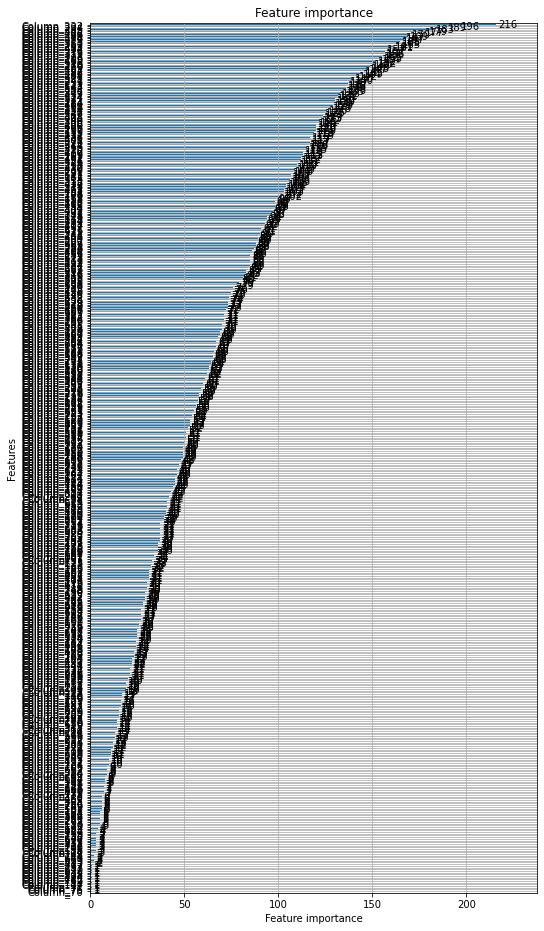

In [ ]:
lgb.plot_importance(gbm,height=0.5,figsize=(8,16))

In [ ]:
import matplotlib.pyplot as plt
plt.savefig('mnist_lgb_plot_importance.png')

<Figure size 432x288 with 0 Axes>

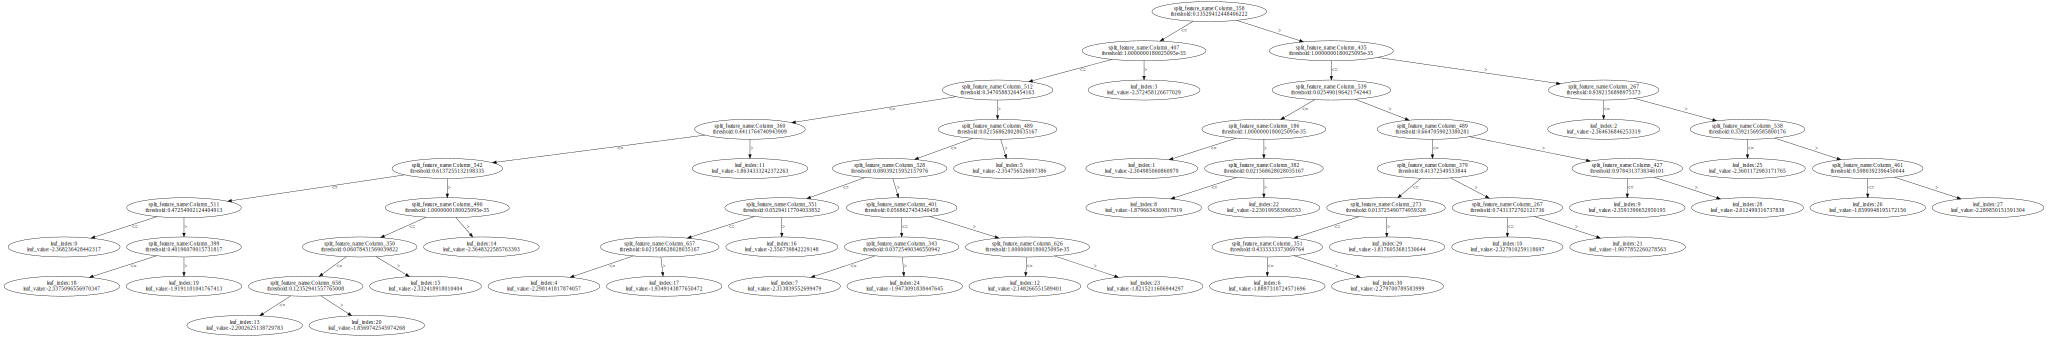

In [ ]:
lgb.create_tree_digraph(gbm)

In [ ]:
## 予測
preds = gbm.predict(test_X)
test_pred = []
for pred in preds:
  test_pred.append(np.argmax(pred))

print('elapsed_timetime:{}'.format(end-start))
print('accuracy_score:{}'.format(accuracy_score(test_y, test_pred)))

elapsed_timetime:0.511263370513916
accuracy_score:0.9718


In [ ]:
if not os.path.exists('mnist_model_lgb.pkl'):
    # save model
    joblib.dump(gbm, 'mnist_model_lgb.pkl')
    gbm.save_model('mnist_model_lgb.txt')


## Keras(NN)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## 前処理

train_y = to_categorical(train_y)
valid_y = to_categorical(valid_y)
# test_y = to_categorical(test_y)

In [ ]:
#経過時間計測
import time
start = time.time()

## 学習

# パラメータの設定
n_features = 784
n_hidden   = 100
bias_init = 0.1

# 学習率
rate       = 0.01

# Sequentialクラスを使ってモデルを準備する
model = Sequential()

# 隠れ層を追加
model.add(Dense(n_hidden,activation='relu',input_shape=(n_features,)))
model.add(Dense(n_hidden,activation='relu'))
model.add(Dense(n_hidden,activation='relu'))

# 出力層を追加
model.add(Dense(10,activation='softmax'))

# TensorFlowのモデルを構築
model.compile(optimizer=tf.optimizers.Adam(rate),
              loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

if os.path.exists('mnist_model_keras_nn.h5'):
    model = keras.models.load_model("mnist_model_keras_nn.h5")
else:
    # Early stoppingを適用してフィッティング
    log = model.fit(train_X, train_y, epochs=3000, batch_size=100, verbose=True,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        min_delta=0, patience=10, 
                                                            verbose=1)],
                    validation_data=(valid_X, valid_y))


# 経過時間
end = time.time()

In [ ]:
# 予測

# テストデータの出力から0~9のどの値か判断
test_pred = np.argmax(model.predict(test_X), axis=1)
# print(sum(test_pred ==test_y)/len(test_pred))

print('elapsed_timetime:{}'.format(end-start))
print('accuracy_score:{}'.format(accuracy_score(test_y, test_pred)))


elapsed_timetime:1.3080675601959229
accuracy_score:0.9681


In [ ]:
# モデルの保存
if not os.path.exists('mnist_model_keras_nn.h5'):
    model.save('mnist_model_keras_nn.h5')


## Keras(CNN)

In [ ]:
from tensorflow.keras import layers, models

# 前処理

# Kerasに付属の手書き数字画像データをダウンロード
(train_X_base, train_y_base), (test_X, test_y) = mnist.load_data()

# Training set を学習データと検証データに8:2で分割する
train_X, valid_X, train_y, valid_y = train_test_split(train_X_base, train_y_base, test_size = 0.2)

print(train_X.shape,valid_X.shape,test_X.shape)
# 各画像のShapeを整形
train_X = train_X.reshape((48000, 28, 28, 1))
valid_X = valid_X.reshape((12000, 28, 28, 1))
test_X = test_X.reshape((10000,28,28,1))
print(train_X.shape,valid_X.shape,test_X.shape)

#正規化
train_X = np.array(train_X).astype('float32')/255
valid_X = np.array(valid_X).astype('float32')/255
test_X = np.array(test_X).astype('float32')/255

# train_y, valid_y をダミー変数化
train_y = to_categorical(train_y)
valid_y = to_categorical(valid_y)


(48000, 28, 28) (12000, 28, 28) (10000, 28, 28)
(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# モデルを構築
model.compile(optimizer=tf.optimizers.Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

if os.path.exists('mnist_model_keras_cnn.h5'):
    model = tf.keras.models.load_model("mnist_model_keras_cnn.h5")
else:
    # Early stoppingを適用してフィッティング
    log = model.fit(train_X, train_y, epochs=100, batch_size=10, verbose=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        min_delta=0, patience=10, 
                                                            verbose=1)],
                    validation_data=(valid_X, valid_y))

end = time.time()



In [ ]:
# テストデータの出力から0~9のどの値か判断
test_pred = np.argmax(model.predict(test_X), axis=1)
# print(sum(test_pred == test_y)/len(test_pred))
print('elapsed_timetime:{}'.format(end-start))
print('accuracy_score:{}'.format(accuracy_score(test_y, test_pred)))


elapsed_timetime:8.70525860786438
accuracy_score:0.9904


In [ ]:
# モデルの保存
if not os.path.exists('mnist_model_keras_cnn.h5'):
    model.save('mnist_model_keras_cnn.h5')

## 【はじめの一歩】CNN実装コード説明（MNIST：手書き数字文字識別） - Qiita
https://qiita.com/DeepTama/items/f3f2b297cb4d0298b803

[[Google Colab] 学習を中断した後、途中から再開する方法 - Qiita](https://qiita.com/kotai2003/items/4bc6d6174bb3e8461c6d)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# import keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def mnist_cnn(input_shape):
    v_input = Input(shape=input_shape)# 入力層
    v_conv2d = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(v_input)# 畳み込み
    v_conv2d1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(v_conv2d)# 畳み込み
    v_maxpool2d = MaxPooling2D(pool_size=(2,2))(v_conv2d1)# 最大値プーリング
    v_dropout = Dropout(rate=0.25)(v_maxpool2d)# ドロップアウト
    v_flatten = Flatten(data_format=None)(v_dropout)# 平坦化
    v_dense = Dense(128,activation='relu')(v_flatten)# 全結合
    v_dropout1 = Dropout(rate=0.5)(v_dense)# ドロップアウト
    v_dense1 = Dense(10,activation='softmax')(v_dropout1)# 全結合
    v_model = Model(v_input, v_dense1)# モデル

    return v_model


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers

# load MNIST data
(train_X_base, train_y_base), (test_X_base, test_y_base) = mnist.load_data()
train_X, valid_X, train_y, valid_y = train_test_split(train_X_base, train_y_base, test_size=0.175)

train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32') / 255
valid_X = valid_X.reshape(valid_X.shape[0], 28, 28, 1).astype('float32') / 255
test_X = test_X_base.reshape(test_X_base.shape[0], 28, 28, 1).astype('float32') / 255

# convert one-hot vector
train_y = to_categorical(train_y, 10)
valid_y = to_categorical(valid_y, 10)
test_y = to_categorical(test_y_base, 10)


epochs=5
batch_size=128

# create model
model = mnist_cnn(input_shape=(28, 28, 1))

model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(),
            metrics=['accuracy'])

print(model.summary())

import datetime

# callback function
NAME = "CNN_{}".format(datetime.datetime.now().isoformat(timespec='seconds')).replace(':', '-')

os.makedirs('checkpoints', exist_ok=True)

checkpoint_file_pattern = 'checkpoints/weights.{epoch:02d}-{val_loss:.3f}.hdf5'

# Callback関数
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_pattern,
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)  # 精度が向上した場合のみ保存する。
tensorboard = tf.keras.callbacks.TensorBoard(
                            log_dir="logs/{}".format(NAME),
                            histogram_freq=1,
                            write_images=True)
# 2回連続で0以上val_lossが改善しない場合Stop
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 min_delta=0,
                                                 patience=2,
                                                 verbose=1)
# モデルの読み込み
if os.path.exists('mnist_model_keras_cnn.h5'):
    model = tf. keras.models.load_model('mnist_model_keras_cnn.h5')
    model.load_weights('mnist_model_keras_cnn_weights.h5')

else:
    ## train
    history = model.fit(train_X, train_y,
                        batch_size=batch_size, epochs=epochs,
                        verbose=1,
                        validation_data=(valid_X, valid_y),
                        callbacks=[checkpoint,tensorboard,earlystopping])


    # result
    score = model.evaluate(test_X, test_y, verbose=0)
    print('Test loss: {0}'.format(score[0]))
    print('Test accuracy: {0}'.format(score[1]))




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                             

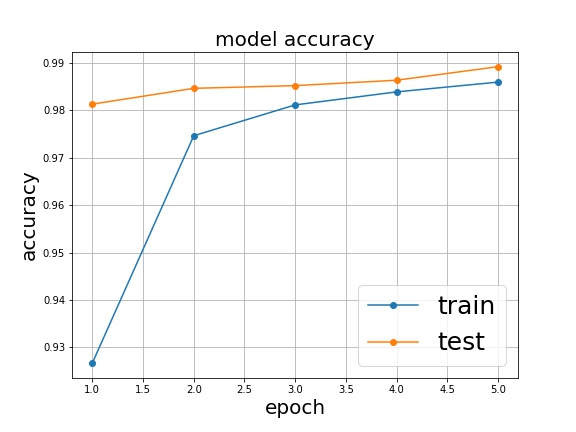

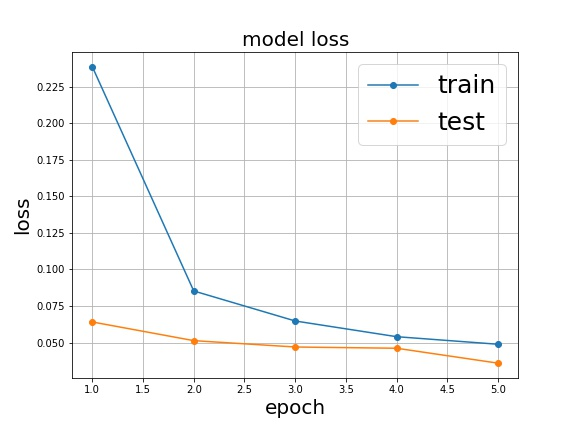

In [ ]:
def plot_history(history,name_accuracy,name_loss):
    # グラフ描画
    # Accuracy
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1,len(history.history['loss'])+1), history.history['accuracy'], "o-", label='train accuracy')
    ax.plot(range(1,len(history.history['loss'])+1), history.history['val_accuracy'], "o-", label='test accuracy')
    ax.set_xlabel('epoch', fontsize='20')
    ax.set_ylabel('accuracy', fontsize='20')
    ax.set_title('model accuracy', fontsize='20')
    ax.grid()
    # ax.legend(['train', 'test'], loc='upper left',fontsize='25')
    ax.legend(['train', 'test'], fontsize='25')
    plt.show()
    fig.savefig(name_accuracy)


    # loss
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1,len(history.history['loss'])+1), history.history['loss'], "o-", label='train loss')
    ax.plot(range(1,len(history.history['loss'])+1), history.history['val_loss'], "o-", label='test loss')
    ax.set_xlabel('epoch', fontsize='20')
    ax.set_ylabel('loss', fontsize='20')
    ax.set_title('model loss', fontsize='20')
    ax.grid()
    # ax.legend(['train', 'test'], loc='upper right',fontsize='25')
    ax.legend(['train', 'test'], fontsize='25')
    plt.show()
    fig.savefig(name_loss)

from IPython.display import Image,display_jpeg

if os.path.exists('train_valid_accurcy_keras_cnn.jpg'):
    display_jpeg(Image('train_valid_accurcy_keras_cnn.jpg'))
    display_jpeg(Image('train_valid_loss_keras_cnn.jpg'))
else:
    plot_history(history,'train_valid_accurcy_keras_cnn.jpg','train_valid_loss_keras_cnn.jpg')

In [ ]:
# モデルの保存
if not os.path.exists('mnist_model_keras_cnn.h5'):
    model.save('mnist_model_keras_cnn.h5')
    model.save_weights('mnist_model_keras_cnn_weights.h5')


### 前回までの重み情報を読んでさらに学習を進める

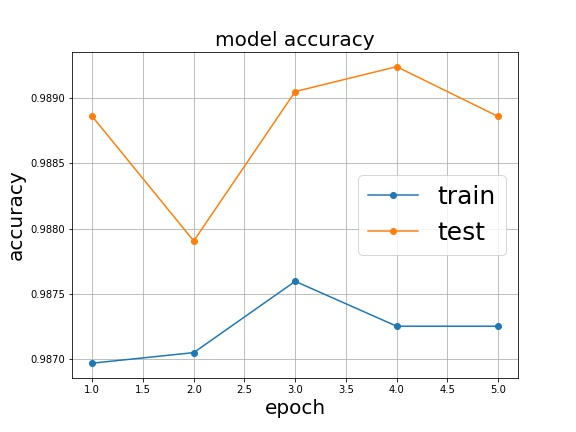

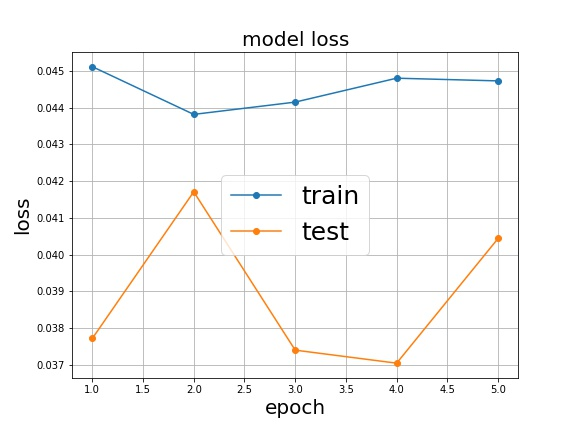

In [ ]:
# 前回のモデルの読み込み

if os.path.exists('mnist_model_keras_cnn_weights.h5'):
    # model.load_weights(os.path.join('checkpoints', 'weights.04-0.041.hdf5'))
    model.load_weights('mnist_model_keras_cnn_weights.h5')



checkpoint_file_pattern = 'checkpoints/weights2.{epoch:02d}-{val_loss:.3f}.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_pattern,
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)  # 精度が向上した場合のみ保存する。
tensorboard = tf.keras.callbacks.TensorBoard(
                            log_dir="logs/{}".format(NAME),
                            histogram_freq=1,
                            write_images=True)
# 2回連続で0以上val_lossが改善しない場合Stop
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 min_delta=0,
                                                 patience=2,
                                                 verbose=1)
# モデルの読み込み
if os.path.exists('mnist_model_keras_cnn2-2.h5'):
    model = tf. keras.models.load_model('mnist_model_keras_cnn2-2.h5')
else:
    # train
    history = model.fit(train_X, train_y,
                        batch_size=batch_size, epochs=epochs,
                        verbose=1,
                        validation_data=(valid_X, valid_y),
                        callbacks=[checkpoint,tensorboard,earlystopping])

if os.path.exists('train_valid_accurcy_keras_cnn2.jpg'):
    display_jpeg(Image('train_valid_accurcy_keras_cnn2.jpg'))
    display_jpeg(Image('train_valid_loss_keras_cnn2.jpg'))
else:
    plot_history(history,'train_valid_accurcy_keras_cnn2.jpg','train_valid_loss_keras_cnn2.jpg')


In [ ]:
# モデルの保存
if not os.path.exists('mnist_model_keras_cnn2-2.h5'):
    model.save('mnist_model_keras_cnn2-2.h5')
    model.save_weights('mnist_model_keras_cnn2-2_weights.h5')

## PyTorch

[【入門】PyTorchの使い方をMNISTデータセットで学ぶ（15分）｜努力のガリレオ](https://dreamer-uma.com/pytorch-mlp-mnist/)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# グラフのスタイルを指定
plt.style.use('seaborn-darkgrid')

In [ ]:
## Load data
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

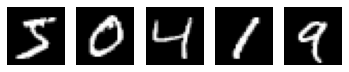

In [ ]:
## View data
fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
    axes[i].axis("off")

In [ ]:
## ミニバッチに分ける
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
## NNの定義
num_classes = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## GPU setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)

## View model
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
## Parameter info
list(model.parameters())

[Parameter containing:
 tensor([[-0.0010, -0.0278, -0.0136,  ...,  0.0296,  0.0222,  0.0234],
         [-0.0050,  0.0241,  0.0097,  ...,  0.0285, -0.0075,  0.0327],
         [ 0.0114, -0.0317, -0.0007,  ..., -0.0266, -0.0169, -0.0111],
         ...,
         [-0.0095, -0.0100, -0.0139,  ...,  0.0205,  0.0345,  0.0216],
         [-0.0233, -0.0324,  0.0197,  ..., -0.0350, -0.0281, -0.0228],
         [ 0.0079,  0.0145,  0.0249,  ..., -0.0073,  0.0285, -0.0210]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0107,  0.0023, -0.0319,  ..., -0.0025, -0.0178, -0.0106],
        requires_grad=True), Parameter containing:
 tensor([[-0.0298,  0.0040,  0.0137,  ...,  0.0154, -0.0041, -0.0264],
         [ 0.0125, -0.0200, -0.0116,  ...,  0.0086,  0.0299, -0.0088],
         [-0.0216,  0.0123,  0.0277,  ..., -0.0255,  0.0295, -0.0149],
         ...,
         [ 0.0236, -0.0098,  0.0304,  ..., -0.0067,  0.0014,  0.0013],
         [-0.0199, -0.0044, -0.0145,  ..., -0.0107,  0.0291,  0.02

In [ ]:
## 適当なデータをモデルに入れる
input_samples = torch.randn(5, 784, device=device)
model(input_samples)

tensor([[ 0.0320, -0.1297, -0.0232,  0.1243, -0.0575, -0.0154, -0.0146,  0.2343,
         -0.0444,  0.0431],
        [ 0.0942, -0.0856, -0.0595,  0.0712,  0.0188, -0.0659, -0.1984, -0.0064,
         -0.0923, -0.1557],
        [ 0.0551, -0.1012, -0.0310, -0.0144,  0.0051,  0.0923, -0.1511,  0.0846,
         -0.0048, -0.0633],
        [ 0.0574, -0.1659, -0.0511,  0.0900,  0.0402,  0.1414, -0.0857,  0.0491,
         -0.0265,  0.0649],
        [ 0.1198, -0.1192, -0.0888, -0.0322,  0.0374,  0.0440, -0.0015, -0.0538,
         -0.0515,  0.0600]], grad_fn=<AddmmBackward0>)

In [ ]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# 損失関数の設定(交差エントロピー)
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定(確率的勾配降下法)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
## エポックを学習するための関数
def train_epoch(model, optimizer, criterion, dataloader, device):
    train_loss = 0
    # trainモード
    model.train()

    for step, (images, labels) in enumerate(dataloader):
        # viewで1次元配列に変更
        # toでgpuに転送
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        # 勾配をリセット
        optimizer.zero_grad()
        # 順伝搬の計算
        outputs = model(images)
        # lossを計算
        loss = criterion(outputs, labels)
        # 逆伝搬の計算
        loss.backward()
        # 重みの更新
        optimizer.step()
        # lossのミニバッチ分を加算
        train_loss += loss.item()
    # データ数で割る
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

## 推論用関数
def inference(model, optimizer, criterion, dataloader, device):
    # 評価モードに切り替え
    model.eval()
    test_loss=0

    # 評価するとき勾配を計算しないように加える
    with torch.no_grad():
        for j, (images, labels) in enumerate(test_loader):
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader.dataset)
    return test_loss

## 学習用関数
def run(num_epochs, optimizer, criterion, device):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, optimizer, criterion, train_loader, device)
        test_loss = inference(model, optimizer, criterion, test_loader, device)

        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f}')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    return train_loss_list, test_loss_list

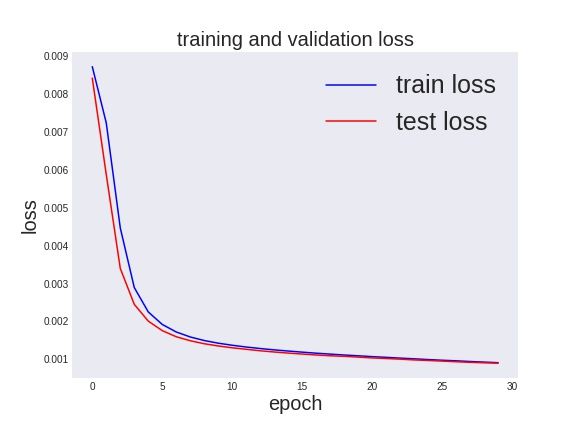

In [ ]:
if os.path.exists('mnist_model_pytorch_nn.pth'):
    model.load_state_dict(torch.load("mnist_model_pytorch_nn.pth"))
    display_jpeg(Image('train_valid_loss_pytorch.jpg'))
else:
    ## 実行
    train_loss_list, test_loss_list = run(30, optimizer, criterion, device)

    ## 訓練誤差とテスト誤差をプロット
    num_epochs=30
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
    ax.plot(range(num_epochs), test_loss_list, c='r', label='test loss')
    ax.set_xlabel('epoch', fontsize='20')
    ax.set_ylabel('loss', fontsize='20')
    ax.set_title('training and validation loss', fontsize='20')
    ax.grid()
    ax.legend(fontsize='25')
    plt.show()

    fig.savefig('train_valid_loss_pytorch.jpg')

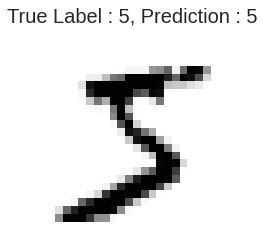

In [ ]:
## 実際に判別できるかの確認
# datasetからサンプルを一つ取り出す
image, label = train_dataset[0]
sample = train_dataset[0][0].view(-1, 28*28)

# 学習後のモデルに予測される
prediction_label = torch.argmax(model(sample))

fig, ax = plt.subplots()
ax.imshow(sample.detach().to('cpu').numpy().reshape(28, 28))
ax.axis('off')
ax.set_title(f'True Label : {label}, Prediction : {prediction_label}', fontsize=20)
plt.show()

In [ ]:
# モデルを保存する。
if not os.path.exists('mnist_model_pytorch_nn.pth'):
    torch.save(model.state_dict(), "mnist_model_pytorch_nn.pth")

## PyTorch(NN) 

[【やってみた】PyTorchでMNIST（モデル構築編）](https://zenn.dev/opamp/articles/1f481b3af41db4)

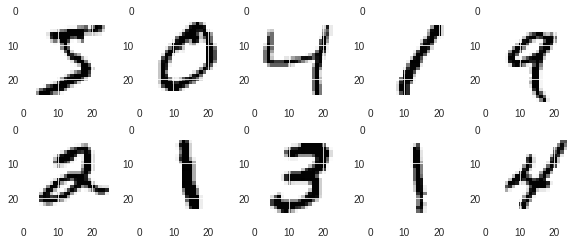

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

transform = T.Compose([T.ToTensor()])
traindata = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
trainloader = DataLoader(traindata,batch_size = 64)

test_data = torchvision.datasets.MNIST(root='./data', train=False,download=True,transform=transform)
test_loader = DataLoader(test_data,batch_size = 64)

data,label = iter(trainloader).next()
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,4))

for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(data[i,0])

In [ ]:
## モデル構築
import torch.nn as nn
class Custom_Model(nn.Module):
    def __init__(self):
        super(Custom_Model,self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1,16,3,padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,16,3,padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16,32,3,padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(7*7*32 , 10)
        )
    def forward(self,x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
# PyTorchでValidation Datasetを作る方法 - Qiita
# https://qiita.com/takurooo/items/ba8c509eaab080e2752c
from torch.utils.data.dataset import Subset

trainvaldata = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
data_len = len(trainvaldata)

train_len = int(data_len*0.8)

train_dataset = Subset(trainvaldata , [i for i in range(0,train_len)])
val_dataset = Subset(trainvaldata , [i for i in range(train_len,data_len)])

train_loader = DataLoader(train_dataset,batch_size = 64)
val_loader = DataLoader(val_dataset,batch_size = 64)

In [ ]:
train_loader

In [ ]:
## 損失関数/最適化関数
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
## 学習
# 学習の経過を表示する関数
def show_score(epoch,max_epoch,itr,max_itr,loss,acc,is_val=False):
    print('\r{} EPOCH[{:03}/{:03}] ITR [{:04}/{:04}] LOSS:{:.05f} ACC:{:03f}'.format("VAL  " if is_val else "TRAIN",epoch,max_epoch,itr,max_itr,loss,acc*100),end = '')
# 損失の合計値を計算する関数
def cal_loss(n,batch,total_loss,loss):
    return (total_loss * n + loss*batch)/(n + batch), n + batch
# 正解数を計算する関数
def cal_acc(t,p):
    p_arg = torch.argmax(p,dim=1)
    return torch.sum(t == p_arg)

# 学習部分
def pt_fit(model):
    EPOCH = 10

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for e in range(EPOCH):
        train_total_loss = 0
        val_total_loss = 0
        train_total_acc = 0
        val_total_acc = 0
        counter = 0
        model.train()
        for n,(data,label) in enumerate(train_loader):
            optimizer.zero_grad()
            print(devce)
            data = data.to(device)
            label = label.to(device)
            print(data.shape)
            print(label.shape)
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            train_total_loss , counter = cal_loss(counter,data.shape[0],train_total_loss ,loss.detach().item())
            train_total_acc += cal_acc(label,output)
            show_score(e+1,EPOCH,n+1,len(train_loader),train_total_loss,train_total_acc/counter)
        train_loss.append(train_total_loss)
        train_acc.append(train_total_acc/counter)
        counter = 0
        model.eval()
        print()
        with torch.no_grad():
            for n,(data,label) in enumerate(val_loader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output,label)
                val_total_loss , counter = cal_loss(counter,data.shape[0],val_total_loss ,loss.detach().item())
                val_total_acc += cal_acc(label,output)
                show_score(e+1,EPOCH,n+1,len(train_loader),val_total_loss,val_total_acc/counter,is_val = True)
        val_loss.append(val_total_loss)
        val_acc.append(val_total_acc/counter)
        print()

if os.path.exists('mnist_model_pytorch_nn2.pth'):
    # モデルを読込み
    model.load_state_dict(torch.load("mnist_model_pytorch_nn2.pth"))
    display_jpeg(Image('train_valid_loss_pytorch.jpg'))
else:
    pt_fit(model)
    # モデルを保存
    torch.save(model.state_dict(), "mnist_model_pytorch_nn2.pth")

NameError: ignored

In [ ]:
# モデルを保存する。
if not os.path.exists('mnist_model_pytorch_nn2.pth'):
    torch.save(model.state_dict(), "mnist_model_pytorch_nn2.pth")